In [ ]:
import sys
sys.path.append('../')
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from utils.dataset import Segmentation_CustomDataset as CustomDataset
import os
import torch.optim as optim
import numpy as np
from utils.__init__ import *
from utils import * 
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [ ]:
tr_img_dir = '/mnt/HDD/chest-seg/dataset/train_img'
tr_mask_dir = '/mnt/HDD/chest-seg/dataset/train_mask' 
vl_img_dir = '/mnt/HDD/chest-seg/dataset/train_img' 
vl_mask_dir = '/mnt/HDD/chest-seg/dataset/train_mask' 

transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(25),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Resize((224, 224)),
        # transforms.RandomResizedCrop(224, scale=(0.75, 1.0), ratio=(0.75, 1.33)),
        # transforms.RandomCrop(size = (224,224), pad_if_needed=True, padding_mode='reflect'),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기와 대비 조정
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
}

# Dataset and DataLoader setup
train_dataset = CustomDataset(
    image_dir = tr_img_dir,
    mask_dir = tr_mask_dir,
    transform=transforms['train'],
    testing=False,
)

valid_dataset = CustomDataset(
    image_dir = vl_img_dir,
    mask_dir = vl_mask_dir,
    transform=transforms['valid'],
    testing=True,  # Disables random transformations for validation
    seed = 627
)
tr_batch, vl_batch = 64, 64
train_loader = DataLoader(dataset = train_dataset, batch_size = tr_batch, shuffle = True)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle = False)

for images, masks in train_loader:
    print(images.shape, masks.shape)
    print(masks.unique())
    train_plotting(images, masks)
    break

# for images, masks, paths in valid_loader:
#     print(images.shape, masks.shape)
#     train_plotting(images, masks)
#     break


In [5]:
import sys 
sys.path.append('../')
from model import swinunet
import torch 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = swinunet.SwinUNet(
    H = 224,
    W = 224,
    ch = 1,
    C = 48,
    num_class = 1,
    num_blocks = 3,
    patch_size = 4).to(device)

for p in model.parameters():
    if p.dim() > 1:
            nn.init.kaiming_uniform_(p)
            
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss().to(device)
metrics = {
    't_bce_loss':[],
    'v_bce_loss':[],
}

####################################################################################################
Train - BCE LOSS : 0.15378248691558838
Valid - BCE LOSS : 0.15070511773228645 

####################################################################################################


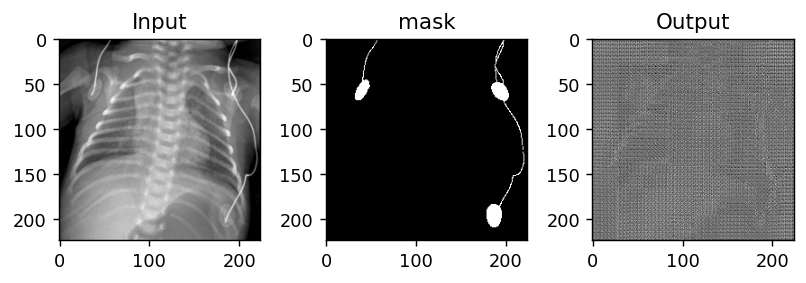

####################################################################################################
Train - BCE LOSS : 0.13521108031272888
Valid - BCE LOSS : 0.1387320403009653 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.12414429802447557
Valid - BCE LOSS : 0.1313089355826378 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.11710053402930498
Valid - BCE LOSS : 0.1264494014903903 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.11235063336789608
Valid - BCE LOSS 

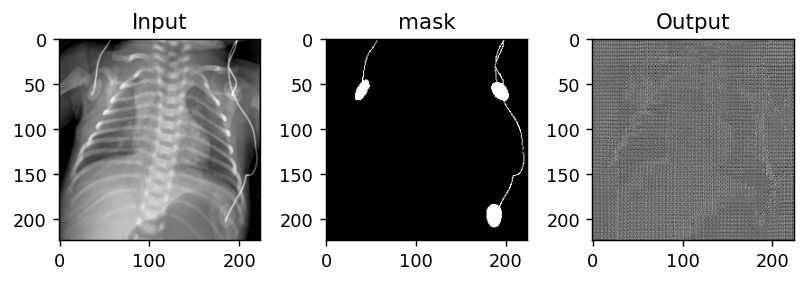

####################################################################################################
Train - BCE LOSS : 0.10653474181890488
Valid - BCE LOSS : 0.11902005597949028 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.10467429459095001
Valid - BCE LOSS : 0.11771403346210718 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.10322941932827234
Valid - BCE LOSS : 0.11670412588864565 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.10208119638264179
Valid - BCE LO

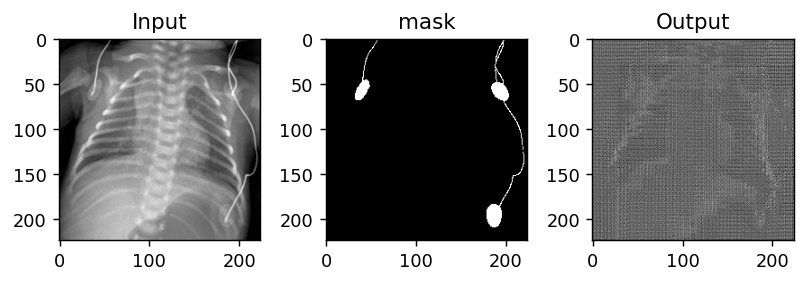

####################################################################################################
Train - BCE LOSS : 0.10037717036902905
Valid - BCE LOSS : 0.11470367107540369 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.0997242359444499
Valid - BCE LOSS : 0.1142316423356533 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.09916025493294
Valid - BCE LOSS : 0.11381104681640863 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.09866233170032501
Valid - BCE LOSS : 

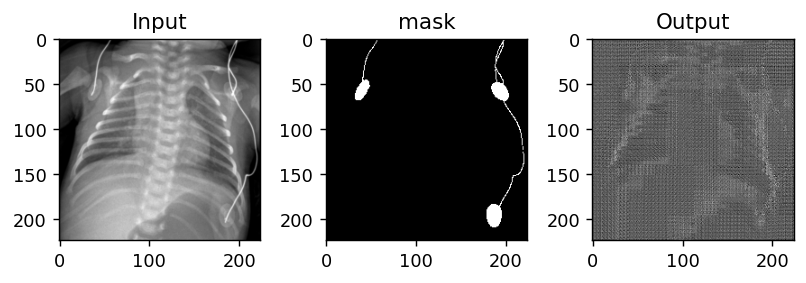

####################################################################################################
Train - BCE LOSS : 0.09779758844524622
Valid - BCE LOSS : 0.11269814055413008 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.09740562085062265
Valid - BCE LOSS : 0.11233914736658335 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.09702769201248884
Valid - BCE LOSS : 0.11197230871766806 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.09665609337389469
Valid - BCE LO

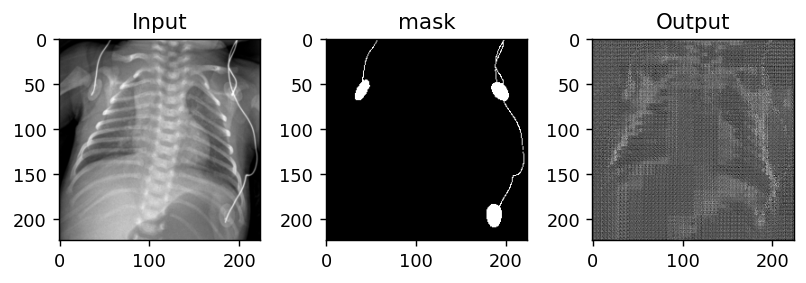

####################################################################################################
Train - BCE LOSS : 0.0959057966247201
Valid - BCE LOSS : 0.11076207272708416 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.09551529120653868
Valid - BCE LOSS : 0.11030249670147896 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.09510680940002203
Valid - BCE LOSS : 0.10980415716767311 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.0946740796789527
Valid - BCE LOSS

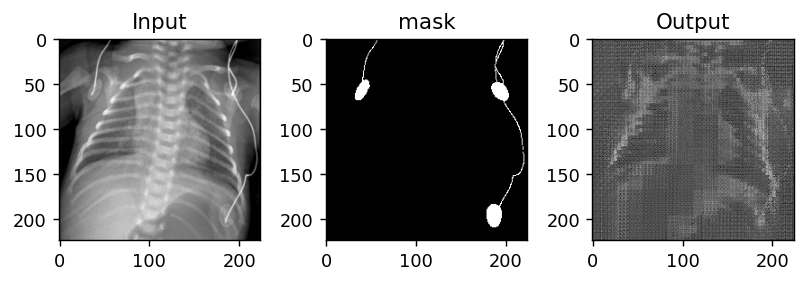

####################################################################################################
Train - BCE LOSS : 0.09370642434805632
Valid - BCE LOSS : 0.10798969399183989 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.09315372072160244
Valid - BCE LOSS : 0.10724376048892736 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.09254119358956814
Valid - BCE LOSS : 0.10641204752027988 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.09185734484344721
Valid - BCE LO

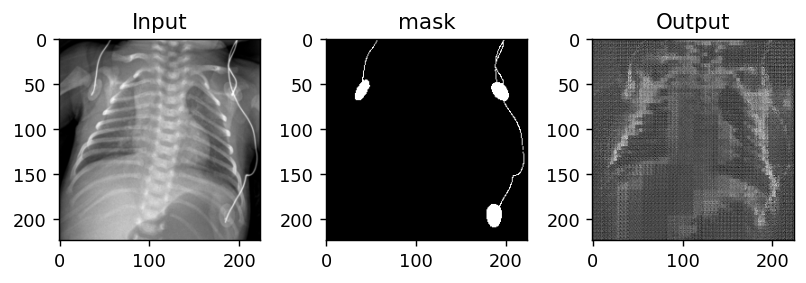

####################################################################################################
Train - BCE LOSS : 0.09023602027446032
Valid - BCE LOSS : 0.10333640035241842 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.08929853141307831
Valid - BCE LOSS : 0.10215335246175528 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.08831277675926685
Valid - BCE LOSS : 0.10098521690815687 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.08732304628938437
Valid - BCE LO

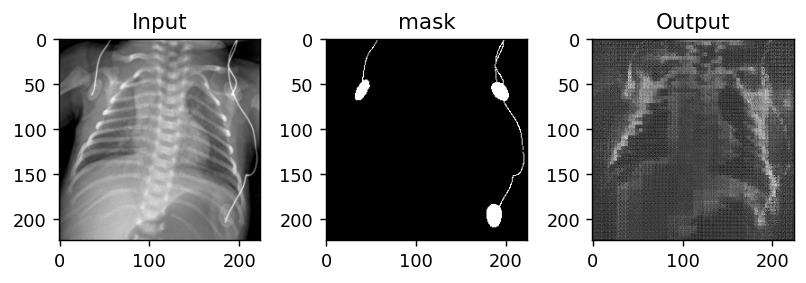

####################################################################################################
Train - BCE LOSS : 0.0853910744190216
Valid - BCE LOSS : 0.09751806315034628 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.0843872120603919
Valid - BCE LOSS : 0.09645323734730482 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.08329946454614401
Valid - BCE LOSS : 0.09531892836093903 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.08210706152021885
Valid - BCE LOSS

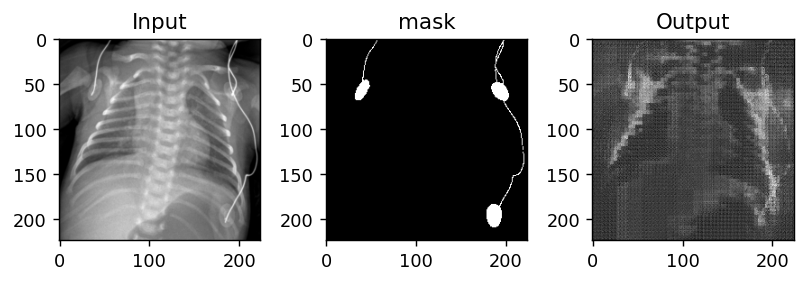

####################################################################################################
Train - BCE LOSS : 0.07943282555788755
Valid - BCE LOSS : 0.09121186751872301 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.0779535137116909
Valid - BCE LOSS : 0.08998800441622734 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.0764796482399106
Valid - BCE LOSS : 0.08899162616580725 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.07502846606075764
Valid - BCE LOSS

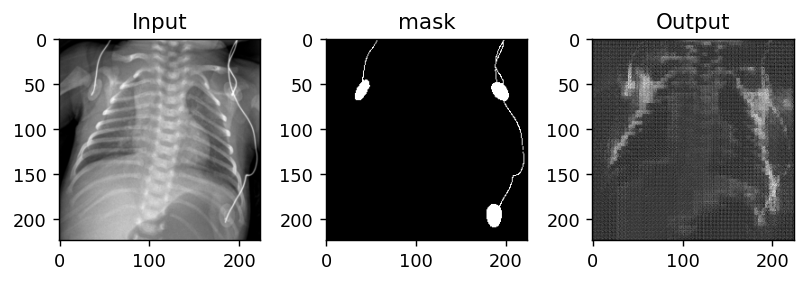

####################################################################################################
Train - BCE LOSS : 0.07329137250781059
Valid - BCE LOSS : 0.08826741948723793 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.07236460968852043
Valid - BCE LOSS : 0.08677305560559034 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.07052426692098379
Valid - BCE LOSS : 0.08579169027507305 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.06870047561824322
Valid - BCE LO

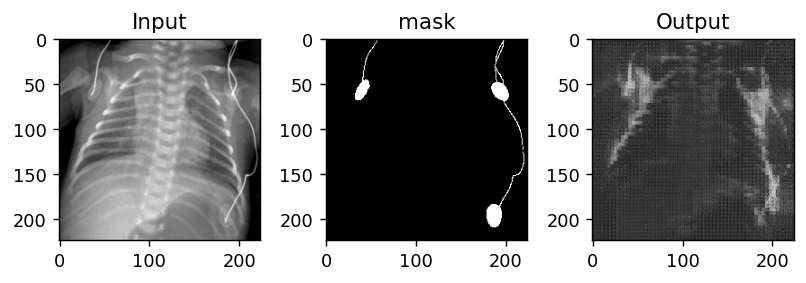

####################################################################################################
Train - BCE LOSS : 0.0669186869636178
Valid - BCE LOSS : 0.08728880155831575 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.06550414394587278
Valid - BCE LOSS : 0.08427804615348577 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.06345292134210467
Valid - BCE LOSS : 0.08435449749231339 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.061861713882535696
Valid - BCE LO

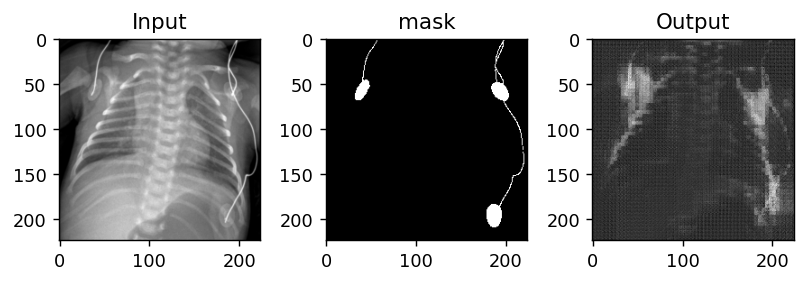

####################################################################################################
Train - BCE LOSS : 0.0588480937294662
Valid - BCE LOSS : 0.08544209413230419 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.057623324915766716
Valid - BCE LOSS : 0.08558713458478451 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.05763029120862484
Valid - BCE LOSS : 0.08430549036711454 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.05666658887639642
Valid - BCE LO

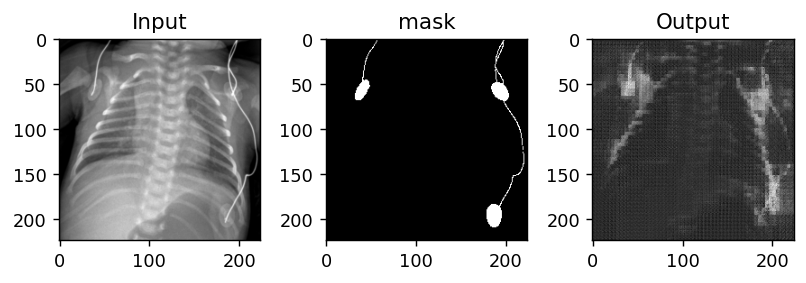

####################################################################################################
Train - BCE LOSS : 0.054276383481919765
Valid - BCE LOSS : 0.08355427253991365 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.05303847510367632
Valid - BCE LOSS : 0.08602895867079496 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.05217071110382676
Valid - BCE LOSS : 0.08597220946103334 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.051231108140200377
Valid - BCE 

KeyboardInterrupt: 

In [4]:
save_path = '/mnt/HDD/chest-seg_models/swin-unet'
os.makedirs(save_path, exist_ok=True)
for epoch in range(500):
    t_losses, v_losses = 0., 0.
    model.train()
    for images, masks in train_loader:
        optimizer.zero_grad()
        images, masks = images.to(device), masks.to(device)
        outputs = model.forward(images.to(device)).to(device)
        
        # BCE Logistic Loss
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        t_losses += loss.cpu().detach().item()

    with torch.no_grad():
        model.eval()
        for images, masks, paths in valid_loader:
            images, masks = images.to(device), masks.to(device)
            ### inference
            outputs = model.forward(images.to(device)).to(device)  # 3+1ch
            
            loss = loss_fn(outputs, masks)
            v_losses += loss.cpu().detach().item()
    if epoch % 5 == 0:
        save_validation(images, masks, outputs, epoch, save_dir = save_path)
    #     save_model(model, optimizer, epoch, save_dir = save_path)
    #     save_loss(metrics, save_dir = save_path)

    metrics['t_bce_loss'].append(t_losses / len(train_loader))
    metrics['v_bce_loss'].append(v_losses / len(valid_loader))

    print("#" * 100)    
    print(f"Train - BCE LOSS : {metrics['t_bce_loss'][-1]}")
    print(f"Valid - BCE LOSS : {metrics['v_bce_loss'][-1]} \n")
    print("#" * 100)
    


In [6]:
# model weight에서 dead weight 파라미터 개수 확인 
# 출력 : dead_weight / total_weight 
dead_weight, total_weight = 0, 0
for p in model.parameters():
    total_weight += p.numel()
    dead_weight += (p == 0).sum().item()
print(f"Dead Weight : {dead_weight} / {total_weight} = {dead_weight / total_weight * 100:.2f} %")



Dead Weight : 14400 / 6827625 = 0.21 %
